<a href="https://colab.research.google.com/github/SathyaKumaragurubaran/Detecting-Duplicate-Question-Pairs-Using-Machine-Learning-Algorithms/blob/main/quora_pair.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install distance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import nltk
from collections import Counter
import distance
from matplotlib import rcParams
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import sys
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.corpus import stopwords
from tqdm import tqdm
from sklearn.preprocessing import normalize
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import collections
%matplotlib inline

Loading Data And Getting Basics Stats

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [ ]:
df.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


Here we can see that we have some missing value in question1 (1 Question) and question2 (2 Question)
3.2.1 Distribution of data points among output classes

<Axes: xlabel='is_duplicate'>

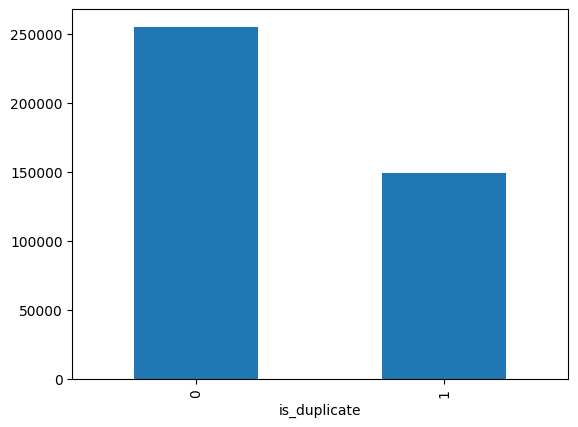

In [ ]:
# Checking if we have imbalance data or not
df.groupby("is_duplicate")['id'].count().plot.bar()

Checking if dataset is balanced or imbalanced

In [ ]:
unique=len(set(list(df['qid1'])+list(df['qid2'])))
print ('Total number of  Unique Questions are: {}\n'.format(unique))

Total number of  Unique Questions are: 537933



Percentage of Similar question and Non-Similar Question

In [ ]:
print('-->> Question pairs are not Similar (is_duplicate = 0):\n     {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('-->> Question pairs are Similar (is_duplicate = 1):\n     {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

-->> Question pairs are not Similar (is_duplicate = 0):
     63.08%
-->> Question pairs are Similar (is_duplicate = 1):
     36.92%


In [ ]:
qids = pd.Series(list(df['qid1']) + list(df['qid2'])) #Creating a dataframe that contains the question id of both quid1 and quid2
unique_qs = len(np.unique(qids))  #Numpy array to filter down all unique elements
qs_morethan_onetime = np.sum(qids.value_counts() > 1)   # Counts any question that have been repeated more than one time
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#len(set(list(df['qid1'])+list(df['qid2'])))


print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,round(qs_morethan_onetime/unique_qs*100,2)))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) # Taking the frequency of all question and printing the max of them

q_vals=qids.value_counts()
print(q_vals)

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.78%)

Max number of times a single question is repeated: 157

2559      157
30782     120
4044      111
2561       88
14376      79
         ... 
416446      1
416444      1
416441      1
416439      1
537933      1
Length: 537933, dtype: int64


Here we can see questions with qid [2559 ,30182 4044] are some the question that are repeated multiple times
Lets have look at those questions one by one

In [ ]:
# Looking at questions that are asked most frequently

print(df.loc[df['qid1']==2559]['question1'].head(1).values)
print('='*50)
print(" "*50)
print(df.loc[df['qid1']==30182]['question1'].head(1).values)
print('='*50)
print(" "*50)
print(df.loc[df['qid1']==4044]['question1'].head(1).values)

['What are the best ways to lose weight?']
                                                  
['How is borderline personality disorder (BPD) treated?']
                                                  
['How can I lose weight quickly?']


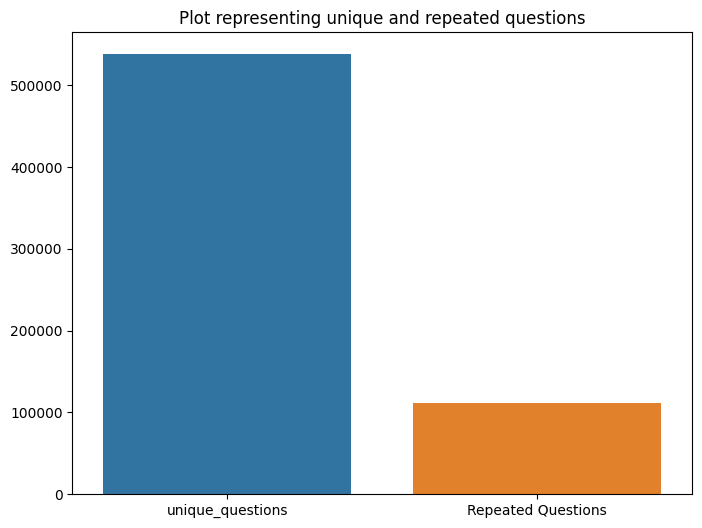

In [ ]:

x = ["unique_questions", "Repeated Questions"]
y = [unique_qs, qs_morethan_onetime]

plt.figure(figsize=(8, 6))
plt.title("Plot representing unique and repeated questions")
sns.barplot(x=x, y=y)
plt.show()

In [ ]:
#checking whether there are any repeated pair of questions

duplicateRowsDF = df[df.duplicated(['qid1','qid2'])]   # Collecting all Duplicate data into a dataframe so than we can also see what duplicate value we have

print ("Number of duplicate questions : ",duplicateRowsDF.shape[0])

Number of duplicate questions :  0


Plotting Questions based on there frequency

Maximum number of times a single question is repeated: 157



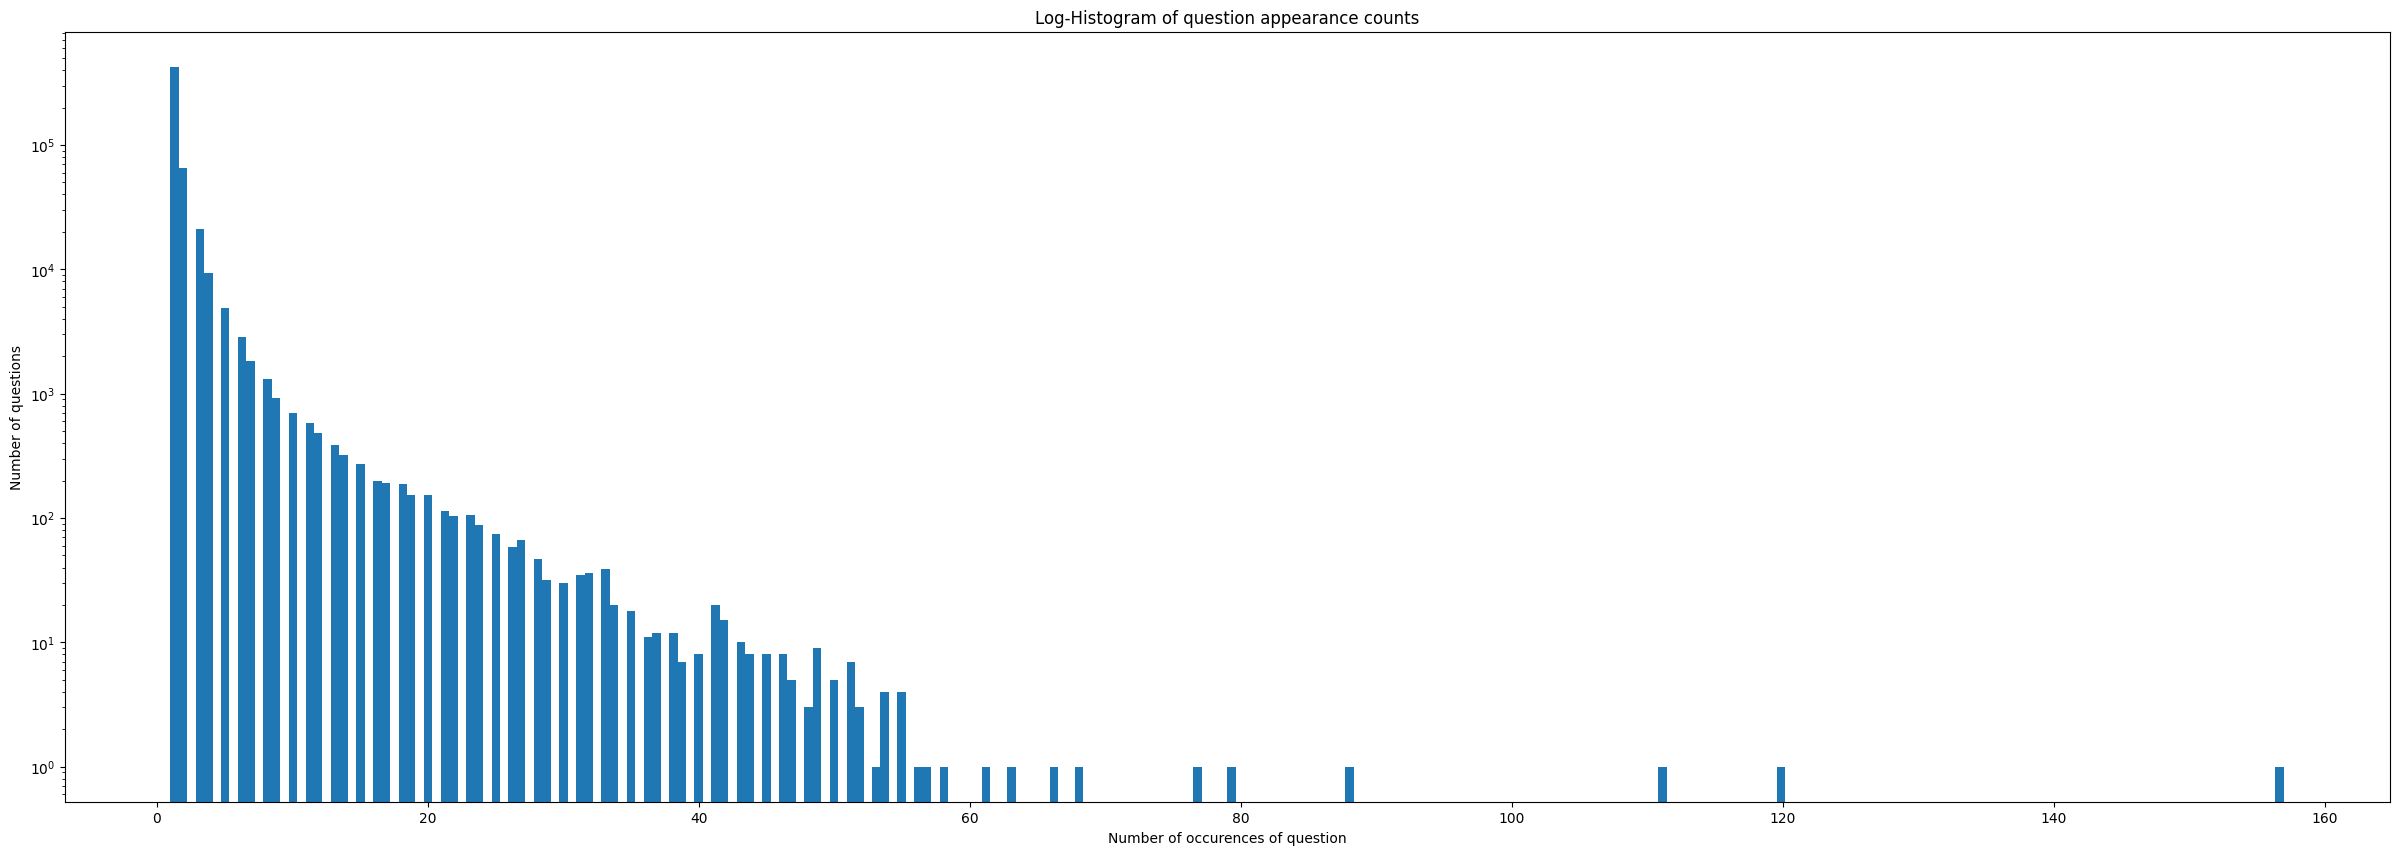

In [ ]:
plt.figure(figsize=(30, 10))

plt.hist(qids.value_counts(), bins=250)

plt.yscale('log')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))

Checking and Removing Null Value

In [ ]:
df[df.isnull().any(1)] # Checking if any value is null in our dataset

<ipython-input-66-5c95d3133d80>:1: FutureWarning:

In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.



,id,qid1,qid2,question1,question2,is_duplicate,Q1_Len,Q2_Len
105780,105780,174363,174364,How can I develop android app?,NaN,0,30.0,NaN
201841,201841,303951,174364,How can I create an Android app?,NaN,0,32.0,NaN
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0,NaN,123.0


In [ ]:
df.dropna(inplace=True)  # Droping Null Value
df[df.isnull().any(1)]

<ipython-input-67-f0d2741a93d6>:2: FutureWarning:

In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.



,id,qid1,qid2,question1,question2,is_duplicate,Q1_Len,Q2_Len


In [ ]:
df['Q1_Len']=df['question1'].str.len()  # Finding length of Question 1
df['Q2_Len']=df['question2'].str.len()  # Finding length of Question 2

df['Q1_Words']=df['question1'].apply(lambda row : len(row.split()))   # Finding Number of Words in Question 1
df['Q2_Words']=df['question2'].apply(lambda row : len(row.split()))   # Finding Number of Words in Question 2

# Fucntion to find the number of common words in Question 1 and Question 2

def common(row):
    '''
    We are converting both Question 1 and Question 2 to set (and also converting them to lower so that every word have same) and finding there intersection so that we can get common words
    Then we are simply finding the lenth of those common words
    '''
    return len((set(row['question1'].lower().split())).intersection(set(row['question2'].lower().split())))


# Creating New Column with Number of Common Words
df['common_Word'] = df.apply(common, axis=1)


# Total Number of Distict words in both question1 and question2

def total(row):
    '''
    Coverting them to lower form then removing extra spaces and them removing the repeted words by converting them to sets
    Then finding Length of Both the questions and adding them to find total words in both
    '''
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return (len(w1) + len(w2))

# Getting total number of (unique) words in both question1 and question2
df['word_Total'] = df.apply(total, axis=1)


def word_share(row):
    '''
    Here we are finding total number of shared word and dividing by total number of words [ (A intersection B)/A+B]
     '''
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))    # Finding the number of common words between question1 and question2 and dividing by total words between both of them
df['Shared_Word'] = df.apply(word_share, axis=1)


# Saving our dataframe as csv file
df.to_csv("With_Feature.csv", index=False)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,Q1_Len,Q2_Len,Q1_Words,Q2_Words,common_Word,word_Total,Shared_Word
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,10,23,0.434783
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,4,20,0.200000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,4,24,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,0,19,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,2,20,0.100000


In [ ]:
print ("Minimum length of the questions in question1 : " , min(df['Q1_Words']))
print ("Minimum length of the questions in question2 : " , min(df['Q2_Words']))

print ("Number of Questions with minimum length [question1] :", df[df['Q1_Words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['Q2_Words']== 1].shape[0])

print ("Maximum length of the questions in question1 : " , max(df['Q1_Words']))
print ("Maximum length of the questions in question2 : " , max(df['Q2_Words']))

print ("Number of Questions with minimum length [question1] :", df[df['Q1_Words']>120].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['Q2_Words']> 230].shape[0])

print ("Maximum number of Common word : " , max(df['common_Word']))
print ("Maximum number of Shared Word : " , max(df['Shared_Word']))

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 69
Number of Questions with minimum length [question2] : 25
Maximum length of the questions in question1 :  125
Maximum length of the questions in question2 :  237
Number of Questions with minimum length [question1] : 1
Number of Questions with minimum length [question2] : 13
Maximum number of Common word :  41
Maximum number of Shared Word :  0.5


**[2]Text pre-processing**
Creating our very own stopword list after removing some stop words like how,whom ,not , etc that may be useful to differentiate between questions

In [ ]:
from nltk.stem import SnowballStemmer
snow=nltk.stem.SnowballStemmer('english')

# Creating custom stopwords

stopwords= set(['the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

Simple fuction to perform stemming while removing StopWords

In [ ]:
def removeStopWord(word):
  token=word.split(" ")   ## coverting string to token (list of word) \\ like ["this","is","token"]
  removestop=[snow.stem(x) for x in token if x not in stopwords]   ##removing stopwords and also doing Stemming
  removed=" ".join(removestop)  ##joing back the list into sentence
  return removed

Replacing common words like 1000 to 1k or 1m and many other and removing special characters

In [ ]:
def preprocess(x):
    x = str(x).lower()  # Lowering all text to covert all of them to there base form

    # Replacing commonly use words or numbers like 1,000 to 1k and 1,000,000 to 1m and currency symbol to there respective names and many other symbols to there name

    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " is")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will").replace("@","at")

    # Renaming 1000 to 1k and 1000000 to 1m (the onces which may not be seperated with commans)
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)


    #Remove any special character like [= , ' ; "" ']

    pattern = re.compile('\W')

    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)

    #Removing Stopwords And Doing Stemming
    x=removeStopWord(x)

    return x

Pre-processing our Questions data (Removing Stop Words, Doing Stemming and more)

In [ ]:
df['cleanQ1']=df['question1'].apply(preprocess)
df['cleanQ2']=df['question2'].apply(preprocess)

Lets look how pre-processing changed the question text




In [ ]:
print('Questions 1 without pre-processing')
print(df['question1'][2])
print()
print('Questions 1 after pre-processing')
print(df['cleanQ1'][2])
print()
print('Questions 2 without pre-processing')
print(df['question2'][2])
print()
print('Questions 2 after pre-processing')
print(df['cleanQ2'][2])

Questions 1 without pre-processing
How can I increase the speed of my internet connection while using a VPN?

Questions 1 after pre-processing
how increas speed internet connect use vpn 

Questions 2 without pre-processing
How can Internet speed be increased by hacking through DNS?

Questions 2 after pre-processing
how internet speed increas hack dns 


**Advance Feature Engineering Using NLP and Fuzzy Features**

Simple Ratio : Measurement of edit distance (Minimum number of edits required to convert one sentence to other )

Partial Ratio : How much accuratly a part of sentence match to other sentence ("Chennai Super Kings", "Super Kings")

Token Sort Ratio : Tokenizing the string in question, sorting the tokens alphabetically, and then joining them back into a string

Token Set Ratio : Tokenize both strings,split the tokens into two groups of intersection and remainder. We use those sets to build up a comparison string.

Last_Word : Checks if last word is same in both Q1 and Q2

First_Word : Checks if First word is same in both Q1 and Q2

Length_diff : Finds the length diffrence between Q1 and Q2

StopWord_Ratio : Number of stopwords in both Questions

Token_Ratio : Number of tokens in both Questions

Longest_Substr_ratio : Ratio of the Longest Substring that is found in between Q1 and Q2

In [ ]:
!pip3 install fuzzywuzzy
!pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.0/174.0 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.2 MB/s eta 0:00:00


In [ ]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

df['Simple_Ratio']=df.apply(lambda x: fuzz.ratio(x['cleanQ1'],x['cleanQ2']) ,axis=1)

df['Partial_Ratio']=df.apply(lambda x: fuzz.partial_ratio(x['cleanQ1'],x['cleanQ2']) ,axis=1)

df['Token_Sort_Ratio']=df.apply(lambda x: fuzz.token_sort_ratio(x['cleanQ1'],x['cleanQ2']) ,axis=1)

df['Token_Set_Ratio']=df.apply(lambda x: fuzz.token_set_ratio(x['cleanQ1'],x['cleanQ2']) ,axis=1)

In [ ]:
df['Last_Word']=df.apply(lambda x: int(x['question1'].split()[-1] == x['question2'].split()[-1]),axis=1)


df['First_Word']=df.apply(lambda x: int(x['question1'].split()[0] == x['question2'].split()[0]),axis=1)


df['Length_diff']=df.apply(lambda x: abs(len(x['question1'].split())-len(x['question2'].split())),axis=1)

In [ ]:
def common_StopWord_Ratio(q1,q2):
    q1_token=q1.split() # Splitting Words to make then tokens
    q2_token=q2.split()

    # We are takking out all the stopwords in both the Question and finding there intersection (Common stopwords)
    q1=set([word for word in q1_token if word in stopwords])
    q2=set([word for word in q2_token if word in stopwords])
    common=q1.intersection(q2)
    ratio=len(common)/len(set(q1_token))+len(set(q2_token))

    return ratio

def common_Token_Ratio(q1,q2):
    q1_token=q1.split()
    q2_token=q2.split()
    # We are takking out all the token in both the Question and finding there intersection (Common tokens)
    q1=set([x for x in q1_token if x not in stopwords])
    q2=set([x for x in q2_token if x not in stopwords])

    common=q1.intersection(q2)
    ratio=len(common)/len(set(q1_token))+len(set(q2_token))

    return ratio
def get_longest_substr_ratio(a, b):

    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return round(len(strs[0]) / (min(len(a), len(b)) + 1),5)

def common_Characters(q1,q2):
    q1="".join(q1.split())
    q2="".join(q2.split())
    c=0
    d=dict(Counter(q1))
    for i in q2:
        if i in d and d[i]!=0:
            c+=1;d[i]-=1
    return c

In [ ]:
df['StopWord_Ratio']=df.apply(lambda x: common_StopWord_Ratio(x["question1"], x["question2"]), axis=1)


df['Token_Ratio']=df.apply(lambda x: common_Token_Ratio(x["question1"], x["question2"]), axis=1)


df['Longest_Substr_ratio']=df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)


# df['Common_Characters']=df.apply(lambda x: common_Characters(x["question1"], x["question2"]), axis=1)

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,Q1_Len,Q2_Len,Q1_Words,Q2_Words,...,Simple_Ratio,Partial_Ratio,Token_Sort_Ratio,Token_Set_Ratio,Last_Word,First_Word,Length_diff,StopWord_Ratio,Token_Ratio,Longest_Substr_ratio
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,...,93,100,93,100,0,1,2,11.416667,11.416667,0.96552
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,...,67,85,65,91,0,1,5,12.125000,12.375000,0.44231
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,...,61,64,75,85,0,1,4,10.071429,10.142857,0.15000
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,...,34,42,29,31,0,0,2,9.000000,9.000000,0.03922
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,...,48,51,51,64,0,1,6,7.076923,7.076923,0.15000


Removing Uncleaned Questions

In [ ]:
# Deleting question1 from our data frame
del df['question1']

# Deleting question2 from our data frame
del df['question2']

# Printing dataset after deletion

df.head()

,id,qid1,qid2,is_duplicate,Q1_Len,Q2_Len,Q1_Words,Q2_Words,common_Word,word_Total,...,Simple_Ratio,Partial_Ratio,Token_Sort_Ratio,Token_Set_Ratio,Last_Word,First_Word,Length_diff,StopWord_Ratio,Token_Ratio,Longest_Substr_ratio
0,0,1,2,0,66,57,14,12,10,23,...,93,100,93,100,0,1,2,11.416667,11.416667,0.96552
1,1,3,4,0,51,88,8,13,4,20,...,67,85,65,91,0,1,5,12.125000,12.375000,0.44231
2,2,5,6,0,73,59,14,10,4,24,...,61,64,75,85,0,1,4,10.071429,10.142857,0.15000
3,3,7,8,0,50,65,11,9,0,19,...,34,42,29,31,0,0,2,9.000000,9.000000,0.03922
4,4,9,10,0,76,39,13,7,2,20,...,48,51,51,64,0,1,6,7.076923,7.076923,0.15000


In [ ]:
# saving our dataframe as csv
df.to_csv('nlp_features_train.csv')

Analysing our extracted features

In [ ]:
# Creating two dataframe of both duplicate and non duplicate and then extacting all the text and saving then in text file
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate['cleanQ1'], df_duplicate['cleanQ2']]).flatten()
n = np.dstack([dfp_nonduplicate["cleanQ1"], dfp_nonduplicate["cleanQ2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_duplicate.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_nonduplicate.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510048


In [ ]:
# reading the text files

textDupli = open('train_duplicate.txt').read()
textNon = open('train_nonduplicate.txt').read()

WordCloud

In [ ]:
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")
stopwords.remove("no")
stopwords.remove("like")


Word Cloud for Duplicate Question pairs


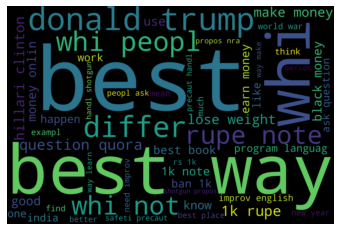

In [ ]:
wc = WordCloud(width = 3000,height = 2000, background_color="black", max_words=50, stopwords=stopwords)
wc.generate(textDupli)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for Duplicate Question pairs


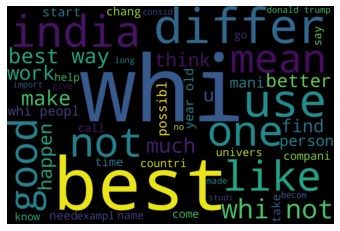

In [ ]:
# Word Clouds generated from non duplicate pair question's text
wc = WordCloud(width = 3000,height = 2000, background_color="black", max_words=50, stopwords=stopwords)
wc.generate(textNon)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
df.columns

Index(['id', 'qid1', 'qid2', 'is_duplicate', 'Q1_Len', 'Q2_Len', 'Q1_Words',
       'Q2_Words', 'common_Word', 'word_Total', 'Shared_Word', 'cleanQ1',
       'cleanQ2', 'Simple_Ratio', 'Partial_Ratio', 'Token_Sort_Ratio',
       'Token_Set_Ratio', 'Last_Word', 'First_Word', 'Length_diff',
       'StopWord_Ratio', 'Token_Ratio', 'Longest_Substr_ratio'],
      dtype='object')

In [ ]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['Simple_Ratio', 'Partial_Ratio', 'Token_Sort_Ratio', 'Token_Set_Ratio','Q1_Len', 'Q2_Len', 'Q1_Words','Q2_Words', 'common_Word', 'word_Total', 'Shared_Word','Last_Word', 'First_Word', 'Length_diff','StopWord_Ratio', 'Token_Ratio', 'Longest_Substr_ratio' ]])
y = dfp_subsampled['is_duplicate'].values

In [ ]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.690s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.097165
[t-SNE] Computed conditional probabilities in 0.215s
[t-SNE] Iteration 50: error = 81.1619720, gradient norm = 0.0528282 (50 iterations in 2.703s)
[t-SNE] Iteration 100: error = 71.7272339, gradient norm = 0.0103732 (50 iterations in 1.709s)
[t-SNE] Iteration 150: error = 70.3985901, gradient norm = 0.0048301 (50 iterations in 1.554s)
[t-SNE] Iteration 200: error = 69.8161697, gradient norm = 0.0039198 (50 iterations in 1.523s)
[t-SNE] Iteration 250: error = 69.4255524, gradient norm = 0.0034035

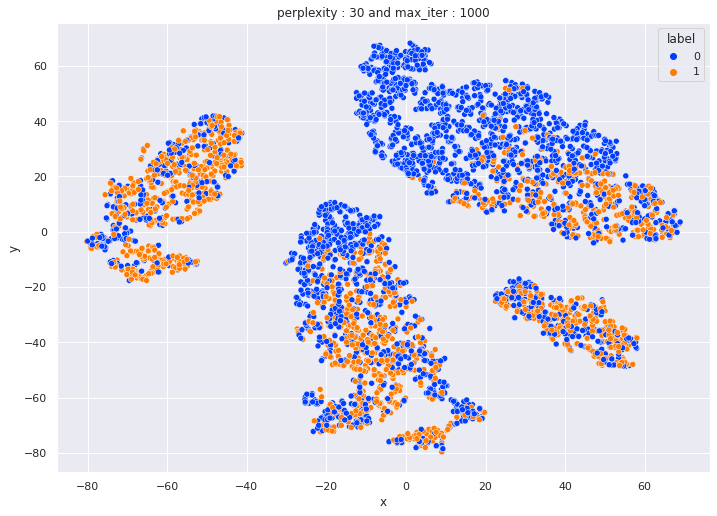

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

palette = sns.color_palette("bright", 2)
# draw the plot in appropriate place in the grid
sns.scatterplot(data=df, x='x', y='y', hue='label',legend='full', palette=palette)
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [ ]:
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.637s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.097165
[t-SNE] Computed conditional probabilities in 0.182s
[t-SNE] Iteration 50: error = 81.6769562, gradient norm = 0.0329560 (50 iterations in 7.766s)
[t-SNE] Iteration 100: error = 71.0420532, gradient norm = 0.0031071 (50 iterations in 4.379s)
[t-SNE] Iteration 150: error = 69.9241943, gradient norm = 0.0016551 (50 iterations in 4.134s)
[t-SNE] Iteration 200: error = 69.4935226, gradient norm = 0.0010804 (50 iterations in 2.992s)
[t-SNE] Iteration 250: error = 69.2412491, gradient norm = 0.0008767

**Featurizing text data**

In [ ]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
df=pd.read_csv('/content/nlp_features_train.csv')
df=df[['cleanQ1','cleanQ2','is_duplicate']]
df['cleanQ1'] = df['cleanQ1'].apply(lambda x: str(x))
df['cleanQ2'] = df['cleanQ2'].apply(lambda x: str(x))
df.head()

,cleanQ1,cleanQ2,is_duplicate
0,what step step guid invest share market india,what step step guid invest share market,0
1,what stori kohinoor koh noor diamond,what would happen indian govern stole kohinoor...,0
2,how increas speed internet connect use vpn,how internet speed increas hack dns,0
3,whi mental lone how solv,find remaind when math 23 24 math divid 2...,0
4,which one dissolv water quik sugar salt meth...,which fish would surviv salt water,0


In [ ]:
# merging questions of both Q1 and Q2 to a single list in which first 404287 index will be of question 1 and then rest of question 2
questions = list(df['cleanQ1']) + list(df['cleanQ2'])  # len(questions): 808574  [404287 of q1 and 404287 of q2]

tfidf = TfidfVectorizer() #  Convert a collection of raw documents to a matrix of TF-IDF features

tfidf.fit_transform(questions)  # Converting out text to a matrix of TF-IDF features

# mapping our feature_names with threre resptive tf-idf score  ( dict key:word and value:tf-idf score )
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



# After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
here we use a pre-trained GLOVE model which comes free with "Spacy". https://spacy.io/usage/vectors-similarity
It is trained on Wikipedia and therefore, it is stronger in terms of word semantics.

In [ ]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []

for qu1 in tqdm(list(df['cleanQ1'])):

    doc1 = nlp(qu1) #creating object of   GLOVE model  so that we can get vetor representation of our words

    # Creating a matrix of N x M where N is is number of word is given line and M i.e. 96 which is the vector representaion of 1st word
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])

    # Looping to all words in the given sentence

    for word1 in doc1:

       # word2vec ( Creating Vector Representation of every word ) which is 96

        vec1 = word1.vector

        # Using try and catch to prefent key error [ For the words that are not there in our word2tfidf dict like empty space ]

        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0

        # adding up all the words generated in the matrix (word2vec matrix * the word2tfidf Corresponding to that word)
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)  # Storing the vector representation of every sentence into an array
df['q1_feats_m'] = list(vecs1)

100%|██████████| 404287/404287 [41:44<00:00, 161.41it/s]


In [ ]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs2 = []

for qu2 in tqdm(list(df['cleanQ2'])):

    doc2 = nlp(qu2) #creating object of   GLOVE model  so that we can get vetor representation of our words

    # Creating a matrix of N x M where N is is number of word is given line and M i.e. 96 which is the vector representaion of 1st word
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])

    # Looping to all words in the given sentence

    for word2 in doc2:

       # word2vec ( Creating Vector Representation of every word ) which is 96

        vec2 = word2.vector

        # Using try and catch to prefent key error [ For the words that are not there in our word2tfidf dict like empty space ]

        try:
            idf = word2tfidf[str(word2)]
        except:
            idf = 0

        # adding up all the words generated in the matrix (word2vec matrix * the word2tfidf Corresponding to that word)
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)  # Storing the vector representation of every sentence into an array
df['q2_feats_m'] = list(vecs2)

100%|██████████| 404287/404287 [41:16<00:00, 163.22it/s]


In [ ]:
df1=pd.read_csv('/content/drive/MyDrive/nlp_features_train.csv')
df1.columns

Index(['Unnamed: 0', 'id', 'qid1', 'qid2', 'is_duplicate', 'Q1_Len', 'Q2_Len',
       'Q1_Words', 'Q2_Words', 'common_Word', 'word_Total', 'Shared_Word',
       'cleanQ1', 'cleanQ2', 'Simple_Ratio', 'Last_Word', 'First_Word',
       'Length_diff', 'Partial_Ratio', 'Token_Sort_Ratio', 'Token_Set_Ratio',
       'StopWord_Ratio', 'Token_Ratio', 'Longest_Substr_ratio'],
      dtype='object')

In [ ]:
df1=df1.drop(['Unnamed: 0','qid1', 'qid2','cleanQ1', 'cleanQ2'],axis=1)
df1.head()

,id,is_duplicate,Q1_Len,Q2_Len,Q1_Words,Q2_Words,common_Word,word_Total,Shared_Word,Simple_Ratio,Last_Word,First_Word,Length_diff,Partial_Ratio,Token_Sort_Ratio,Token_Set_Ratio,StopWord_Ratio,Token_Ratio,Longest_Substr_ratio
0,0,0,66,57,14,12,10,23,0.434783,93,0,1,2,100,93,100,11.416667,11.416667,0.96552
1,1,0,51,88,8,13,4,20,0.200000,67,0,1,5,85,65,91,12.125000,12.375000,0.44231
2,2,0,73,59,14,10,4,24,0.166667,41,0,1,4,42,73,85,10.071429,10.142857,0.15000
3,3,0,50,65,11,9,0,19,0.000000,31,0,0,2,42,26,31,9.000000,9.000000,0.03922
4,4,0,76,39,13,7,2,20,0.100000,34,0,1,6,51,51,64,7.076923,7.076923,0.15000


In [ ]:
df.columns

Index(['cleanQ1', 'cleanQ2', 'is_duplicate', 'q1_feats_m', 'q2_feats_m'], dtype='object')

In [ ]:
df3 = df.drop(['cleanQ1', 'cleanQ2', 'is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [ ]:
if not os.path.isfile('final_features.csv'):
    df3_q1['id']=df1['id']
    df3_q2['id']=df1['id']
#df1  = df1.merge(df2, on='id',how='left')
    df2  = df3_q1.merge(df3_q2, on='id',how='left')
    result  = df1.merge(df2, on='id',how='left')
    result.to_csv('final_features.csv')

Machine Learning Models

In [ ]:
!pip install mlxtend
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
#from mlxtend.ensemble import StackingClassifier


from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

import numpy as np # linear algebra
import pandas as pd
data=pd.read_csv('/content/drive/MyDrive/final_features.csv')
data.head()

,Unnamed: 0,id,is_duplicate,Q1_Len,Q2_Len,Q1_Words,Q2_Words,common_Word,word_Total,Shared_Word,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,0,0,66,57,14,12,10,23,0.434783,...,-31.102127,0.505053,-6.579380,13.620158,-21.274156,-26.323503,11.100339,51.306917,25.711143,21.282153
1,1,1,0,51,88,8,13,4,20,0.200000,...,-32.732204,-46.000155,-24.624922,43.772465,-18.766885,-35.293539,5.515999,70.623898,1.168298,38.812205
2,2,2,0,73,59,14,10,4,24,0.166667,...,-13.857879,-15.160576,-8.154185,20.343424,24.222691,-42.427997,-2.470406,23.679811,19.482093,10.804921
3,3,3,0,50,65,11,9,0,19,0.000000,...,20.284351,6.163535,5.949984,49.610703,7.629435,-34.266763,-11.635811,46.955974,-14.216256,17.761809
4,4,4,0,76,39,13,7,2,20,0.100000,...,-6.970851,4.204248,-33.061137,9.762033,3.128604,-15.732558,14.741596,17.810421,15.252085,14.802671


In [ ]:
y_true=data['is_duplicate']
data.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)

In [ ]:
scaler = StandardScaler()
# transform data
scaled = scaler.fit_transform(data)

In [ ]:
X_train,X_test, y_train, y_test = train_test_split(scaled, y_true, stratify=y_true, test_size=0.3)

In [ ]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (283000, 209)
Number of data points in test data : (121287, 209)


In [ ]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6307985865724381 Class 1:  0.36920141342756185
---------- Distribution of output variable in train data ----------
Class 0:  0.3691986775169639 Class 1:  0.3691986775169639


In [ ]:
from imblearn.over_sampling import SMOTE
counter = Counter(y_train)
print('Before',counter)

sm = SMOTE()

# transform the dataset
X_train, y_train = sm.fit_resample(X_train, y_train)

counter = Counter(y_train)
print('After',counter)

Before Counter({0: 204019, 1: 119410})
After Counter({1: 204019, 0: 204019})


Accuracy: 72.23%
Precision: 59.67%
Recall: 76.48%
F1 Score: 67.03%


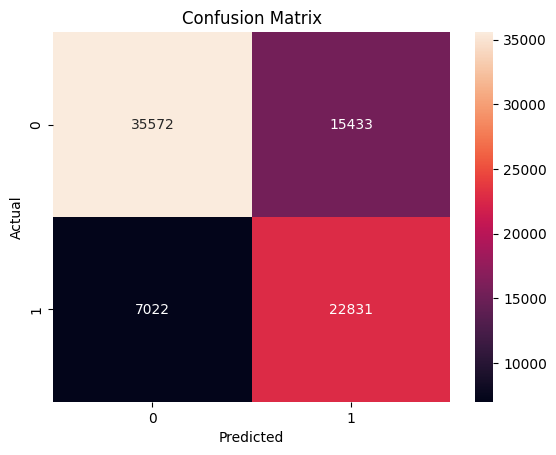

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Train the logistic regression model
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Precision: {:.2f}%".format(precision*100))
print("Recall: {:.2f}%".format(recall*100))
print("F1 Score: {:.2f}%".format(f1*100))

# plot confusion matrix with heatmap
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



Accuracy: 72.64%
Precision: 62.77%
Recall: 63.67%
F1 Score: 63.21%


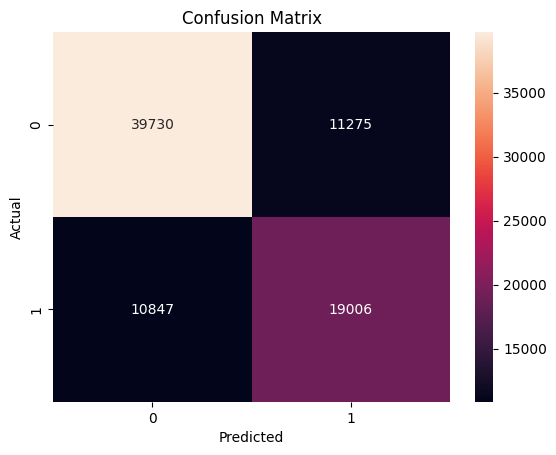

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# Train the model
model = DecisionTreeClassifier(random_state=27)
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Precision: {:.2f}%".format(precision*100))
print("Recall: {:.2f}%".format(recall*100))
print("F1 Score: {:.2f}%".format(f1*100))

# plot confusion matrix with heatmap
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Accuracy: 78.10%
Precision: 66.96%
Recall: 80.32%
F1 Score: 73.04%


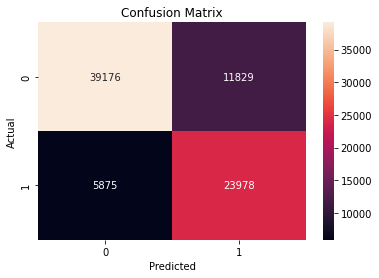

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Apply SMOTE to the training set
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train the model
k = 5
model = KNeighborsClassifier(n_neighbors=k)
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Precision: {:.2f}%".format(precision*100))
print("Recall: {:.2f}%".format(recall*100))
print("F1 Score: {:.2f}%".format(f1*100))

# plot confusion matrix with heatmap
sns.heatmap(confusion_mat, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy: 77.95%
Precision: 69.34%
Recall: 72.20%
F1 Score: 70.75%


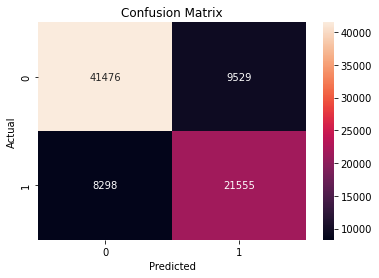

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load the data
# X_train, y_train, X_test, y_test = load_data()

# Define classifiers
knn = KNeighborsClassifier(n_neighbors=5)
dt = DecisionTreeClassifier(random_state=42)
lr = LogisticRegression(random_state=42)

# Create the Voting Classifier
voting = VotingClassifier(estimators=[('knn', knn), ('dt', dt), ('lr', lr)], voting='hard')

# Train the model
voting.fit(X_train, y_train)

# Make predictions on test set
y_pred = voting.predict(X_test)

# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Precision: {:.2f}%".format(precision*100))
print("Recall: {:.2f}%".format(recall*100))
print("F1 Score: {:.2f}%".format(f1*100))

# plot confusion matrix with heatmap
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



Accuracy: 80.24%
Precision: 72.53%
Recall: 74.79%
F1 Score: 73.65%


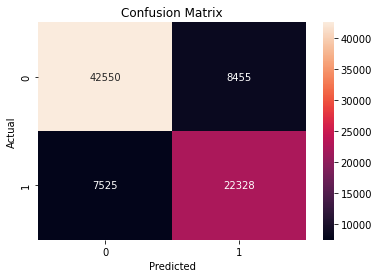

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix

# Assuming X_train, y_train, X_test, y_test are already defined

# Train the model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

# Make predictions on test data
y_pred = xgb_model.predict(X_test)


# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Precision: {:.2f}%".format(precision*100))
print("Recall: {:.2f}%".format(recall*100))
print("F1 Score: {:.2f}%".format(f1*100))

# plot confusion matrix with heatmap
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Accuracy: 81.90%
Precision: 77.51%
Recall: 71.83%
F1 Score: 74.56%


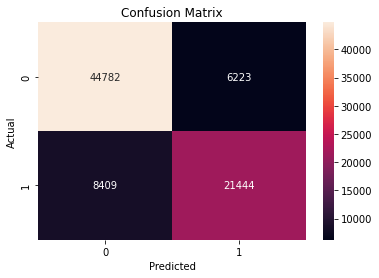

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training set
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize and fit the Extra Trees classifier
etc = ExtraTreesClassifier(n_estimators=400, max_depth=50)
etc.fit(X_train, y_train)

# Predict the test set
y_pred = etc.predict(X_test)

# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Precision: {:.2f}%".format(precision*100))
print("Recall: {:.2f}%".format(recall*100))
print("F1 Score: {:.2f}%".format(f1*100))

# plot confusion matrix with heatmap
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
